In [1]:
"""
参考リスト
https://networkx.github.io/documentation/stable/
-> NetworkXの公式ドキュメント、用法が載っている
http://www.jp.undp.org/content/tokyo/ja/home/sustainable-development-goals.html
-> Sustainable Development Goals（データ出展）
"""
from gensim import corpora, matutils
from janome.tokenizer import Tokenizer
import codecs
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.sparse

In [2]:
# ストップワードの設定、Janomeインスタンスの生成
stop_words = ["平和", "人間"] #全文書に出てくる特徴的でない単語はストップワードとして除く
tokenizer = Tokenizer()

In [3]:
# Janomeでの処理スクリプト（名詞のみ、ストップワードは除く、2文字以上の単語、数字は使用しない）
def token_generator(text):
    for text_line in text.split('\n'):
        for token in tokenizer.tokenize(text_line):
            if token.part_of_speech.split(',')[0] == '名詞' and token.surface not in stop_words:
                if len(token.surface) > 1 and not(token.surface.isdigit()):
                    yield token.surface

In [4]:
# データの読み込み＆形態素解析
text_processed = [ ]
num_files = 17
for i in range(num_files): # ファイルは1からの連番で用意している前提です
    file_path = "./files_step4/data/SDGs"+str(i+1)+".txt"
    with open(file_path) as f:
        txt = f.read()
        text_processed.append(list(token_generator(txt)))

In [5]:
# 辞書の作成と保存
dictionary = corpora.Dictionary(text_processed)
dictionary.save('./files_step6/dictionary.dict')

In [6]:
#BoW matrixの作成＆保存
corpus = [dictionary.doc2bow(doc) for doc in text_processed]
doc_matrix = matutils.corpus2csc(corpus).transpose()
scipy.sparse.save_npz('./files_step6/category_matrix.npz', doc_matrix)

In [7]:
# cos_similarityの作成
cos_sim = np.zeros([num_files, num_files])
var_mat = doc_matrix.dot(doc_matrix.transpose()).toarray()
for i in range(num_files):
    for j in range(num_files):
        cos_sim[i,j] = var_mat[i,j]/(np.sqrt(var_mat[i, i])*np.sqrt(var_mat[j, j]))

print(cos_sim[:6,:6]) # Cos類似度の計算結果の出力

[[1.         0.4066709  0.33468717 0.39066134 0.3614047  0.41174465]
 [0.4066709  1.         0.41572467 0.42044325 0.44107395 0.38054718]
 [0.33468717 0.41572467 1.         0.478755   0.39336604 0.37796447]
 [0.39066134 0.42044325 0.478755   1.         0.44839514 0.3015873 ]
 [0.3614047  0.44107395 0.39336604 0.44839514 1.         0.29106351]
 [0.41174465 0.38054718 0.37796447 0.3015873  0.29106351 1.        ]]


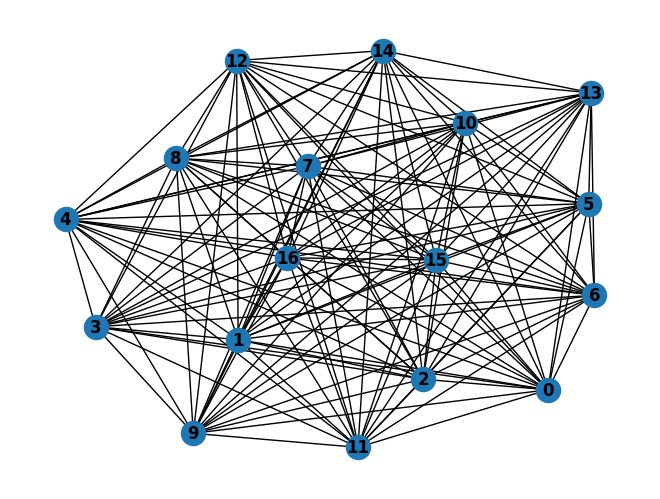

In [8]:
# 隣接行列の作成＆グラフの描画
G=nx.Graph()
for i in range(num_files):
    for j in range(num_files):
        if i != j and cos_sim[i,j]>0.2:  # 閾値を設けて隣接行列を作る
            G.add_edge(str(i),str(j),weight=cos_sim[i,j])

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

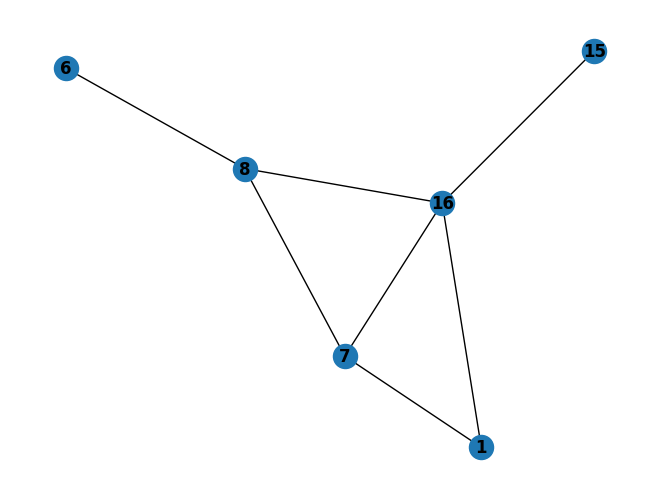

In [9]:
# 隣接行列の作成＆グラフの描画
G=nx.Graph()
for i in range(num_files):
    for j in range(num_files):
        if i != j and cos_sim[i,j]>0.5:  # 閾値を設けて隣接行列を作る
            G.add_edge(str(i),str(j),weight=cos_sim[i,j])

nx.draw(G, with_labels=True, font_weight='bold')
plt.show()